In [ ]:
# Initialize some stuff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.dates import DateFormatter

# A function for plotting data given the date
def plot_energy_stack_by_day(date_str, input_df, vline=None):
    # Filter for the target day
    target_date = pd.to_datetime(date_str).date()
    mask = input_df['start_time'].dt.date == target_date
    df_day = input_df[mask]
    timestamps = df_day['start_time']

    # Define the columns to plot (order matters for stack and legend)
    energy_sources = [
        'Wind',
        'Solar',
        'Other renewables',
        'Nuclear',
        'Hydro',
        'Gas',
        'Coal',
        'Other'
    ]
    reversed_sources = energy_sources[::-1]

    # Plot
    try:
        import UCSmpl
        style_context = plt.style.context('ucs_light')
    except ImportError:
        style_context = plt.style.context('default')

    with style_context:
        plt.rcParams.update({
            'font.size': 18,          # sets the default font size
            'axes.titlesize': 20,     # title font size
            'axes.labelsize': 18,     # x and y label size
            'xtick.labelsize': 16,    # x tick labels
            'ytick.labelsize': 16     # y tick labels
        })
        fig, ax = plt.subplots(figsize=(15, 9), dpi=100)
        ax.stackplot(timestamps, df_day[reversed_sources].T, labels=reversed_sources)

        # Reverse legend order to match stack layers
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[::-1], labels[::-1], loc='upper left', bbox_to_anchor=(1, 1))

        # Format axes
        ax.set_xlim([timestamps.min(), timestamps.max()])
        ax.xaxis.set_major_formatter(DateFormatter('%H'))
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}"))

        # Optional vertical line
        if vline is not None:
            vline_timestamp = pd.to_datetime(vline)
            ax.axvline(vline_timestamp, color='gray', linestyle='--', linewidth=1.5)

        # Plot
        ax.set_title(f'Generation Mix (MW) for {target_date.strftime("%B %d, %Y")}')
        ax.set_xlabel('Hour')
        ax.set_ylabel('Power (MW)')
        plt.xticks()
        plt.tight_layout()
        ax.grid(True)
        plt.show()

In [71]:
## Load the downloaded ENTSO-E data for 2025 to date
spain_raw = pd.read_csv("data/Actual Generation per Production Type_202501010000-202601010000.csv")

In [72]:
# Drop any rows where a "-" appears in any column
spain_raw = spain_raw[~spain_raw.isin(["-"]).any(axis=1)].reset_index(drop=True)

# Extract start time string from 'MTU' column (e.g., "28.04.2025 00:00 - ...")
spain_raw['start_time'] = pd.to_datetime(
    spain_raw['MTU'].str.extract(r'^(.*?) -')[0], dayfirst=True
)

# Drop unused or redundant columns
columns_to_drop = [
    'Area', 'MTU',
    'Fossil Brown coal/Lignite - Actual Aggregated [MW]',
    'Fossil Coal-derived gas - Actual Aggregated [MW]',
    'Fossil Oil shale - Actual Aggregated [MW]',
    'Fossil Peat - Actual Aggregated [MW]',
    'Geothermal - Actual Aggregated [MW]',
    'Marine - Actual Aggregated [MW]',
    'Wind Offshore - Actual Aggregated [MW]'
]
spain_clean = spain_raw.drop(columns=columns_to_drop)

# Ensure values are numeric
energy_columns = spain_clean.columns[:-1]  # all except 'start_time'
spain_clean[energy_columns] = spain_clean[energy_columns].apply(
    pd.to_numeric, errors='coerce'
)

# Rename columns
new_column_names = [
    'Biomass', 'Gas', 'Coal', 'Oil', 'PSH gen', 'PSH con',
    'Small hydro', 'Large hydro', 'Nuclear', 'Other',
    'Misc renewables', 'Solar', 'Waste', 'Wind', 'start_time'
]
spain_clean.columns = new_column_names

# Combine some categories
aggregations = {
    'Other renewables': ['Biomass', 'Misc renewables', 'Waste'],
    'Hydro': ['PSH gen', 'Small hydro', 'Large hydro'],
    'Gas': ['Gas'],
    'Coal': ['Coal'],
    'Other': ['Oil', 'Other'],
    'Nuclear': ['Nuclear'],
    'Solar': ['Solar'],
    'Wind': ['Wind']
}
spain_agg = pd.DataFrame()
spain_agg['start_time'] = spain_clean['start_time']

for category, cols in aggregations.items():
    spain_agg[category] = spain_clean[cols].sum(axis=1)

spain_agg


,start_time,Other renewables,Hydro,Gas,Coal,Other,Nuclear,Solar,Wind
0,2025-01-01 00:00:00,648.0,2784.0,8608.0,512.0,16.0,7116.0,4.0,2856.0
1,2025-01-01 00:15:00,640.0,2980.0,8848.0,500.0,16.0,7116.0,4.0,2904.0
2,2025-01-01 00:30:00,628.0,2964.0,8716.0,468.0,16.0,7116.0,4.0,2972.0
3,2025-01-01 00:45:00,620.0,2876.0,8444.0,436.0,16.0,7116.0,4.0,3064.0
4,2025-01-01 01:00:00,616.0,2744.0,8276.0,392.0,16.0,7116.0,4.0,3096.0
...,...,...,...,...,...,...,...,...,...
18423,2025-07-11 21:45:00,816.0,5588.0,9072.0,0.0,84.0,6924.0,976.0,7460.0
18424,2025-07-11 22:00:00,824.0,6220.0,8996.0,0.0,84.0,6928.0,744.0,7368.0
18425,2025-07-11 22:15:00,820.0,6600.0,9444.0,0.0,84.0,6932.0,652.0,7416.0
18426,2025-07-11 22:30:00,820.0,6520.0,9332.0,0.0,88.0,6936.0,640.0,7444.0


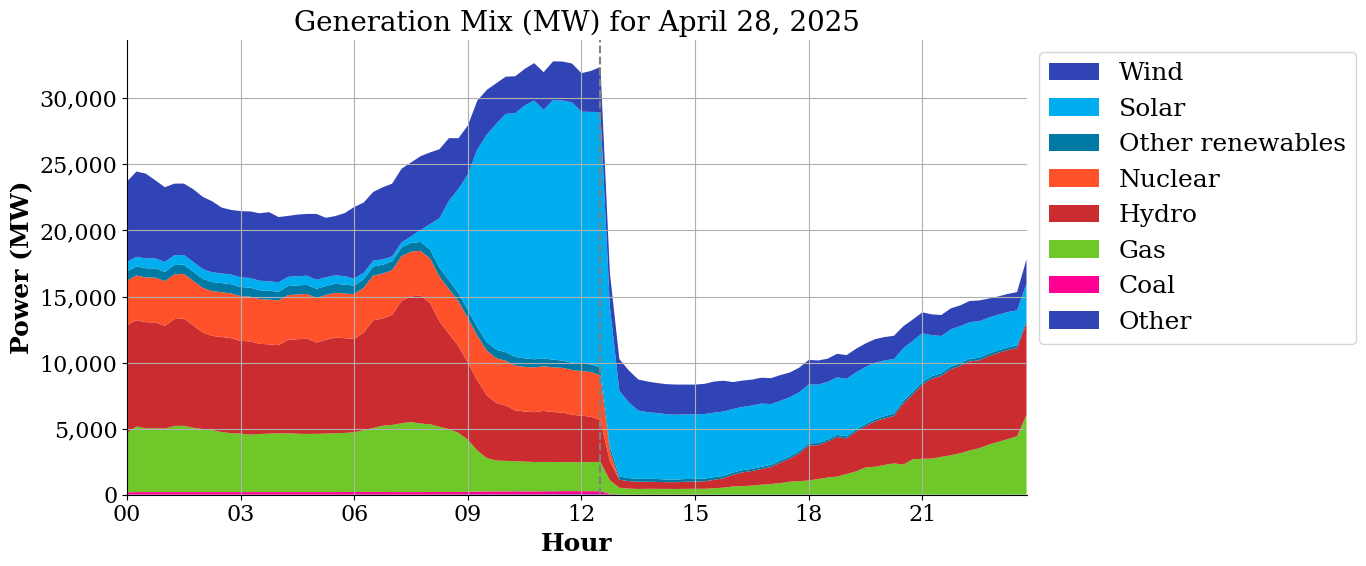

In [73]:
# Plot May 28, since we have to remove it from the data later
plot_energy_stack_by_day('2025-04-28', spain_agg, '2025-04-28 12:30')

In [74]:
# Do some meta-analysis

# Remove everything after 12:30 on 4/28 when the data goes wild
cutoff_datetime = pd.to_datetime('2025-04-28 12:15')
spain_agg = spain_agg[spain_agg['start_time'] <= cutoff_datetime].reset_index(drop=True)

# Total power
gen_cols = spain_agg.columns.drop('start_time')
spain_agg['Total_MW'] = spain_agg[gen_cols].sum(axis=1)

# IBR power
spain_agg['IBR_MW'] = spain_clean['Solar'] + spain_clean['Wind']

# IBR share per 15 min interval
spain_agg['IBR_pc_15'] = spain_agg['IBR_MW'] / spain_agg['Total_MW']

# IBR share per day
spain_agg['date'] = spain_agg['start_time'].dt.date
daily_stats = spain_agg.groupby('date', sort=False).agg({
    'IBR_MW': 'sum',
    'Total_MW': 'sum',
    'IBR_pc_15': 'max'
})
daily_stats['IBR_pc_day'] = daily_stats['IBR_MW'] / daily_stats['Total_MW']
daily_stats.rename(columns={'IBR_pc_15': 'IBR_pc_15_max'}, inplace=True)
spain_agg['IBR_pc_day'] = spain_agg['date'].map(daily_stats['IBR_pc_day'])
spain_agg['IBR_pc_15_max'] = spain_agg['date'].map(daily_stats['IBR_pc_15_max'])

spain_agg

,start_time,Other renewables,Hydro,Gas,Coal,Other,Nuclear,Solar,Wind,Total_MW,IBR_MW,IBR_pc_15,date,IBR_pc_day,IBR_pc_15_max
0,2025-01-01 00:00:00,648.0,2784.0,8608.0,512.0,16.0,7116.0,4.0,2856.0,22544.0,2860.0,0.126863,2025-01-01,0.300077,0.562095
1,2025-01-01 00:15:00,640.0,2980.0,8848.0,500.0,16.0,7116.0,4.0,2904.0,23008.0,2908.0,0.126391,2025-01-01,0.300077,0.562095
2,2025-01-01 00:30:00,628.0,2964.0,8716.0,468.0,16.0,7116.0,4.0,2972.0,22884.0,2976.0,0.130047,2025-01-01,0.300077,0.562095
3,2025-01-01 00:45:00,620.0,2876.0,8444.0,436.0,16.0,7116.0,4.0,3064.0,22576.0,3068.0,0.135897,2025-01-01,0.300077,0.562095
4,2025-01-01 01:00:00,616.0,2744.0,8276.0,392.0,16.0,7116.0,4.0,3096.0,22260.0,3100.0,0.139263,2025-01-01,0.300077,0.562095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11277,2025-04-28 11:15:00,584.0,3780.0,2216.0,232.0,28.0,3384.0,19640.0,2932.0,32796.0,22572.0,0.688255,2025-04-28,0.409283,0.693797
11278,2025-04-28 11:30:00,552.0,3756.0,2192.0,232.0,40.0,3384.0,19684.0,2944.0,32784.0,22628.0,0.690215,2025-04-28,0.409283,0.693797
11279,2025-04-28 11:45:00,556.0,3588.0,2192.0,232.0,40.0,3384.0,19696.0,2944.0,32632.0,22640.0,0.693797,2025-04-28,0.409283,0.693797
11280,2025-04-28 12:00:00,564.0,3520.0,2188.0,232.0,40.0,3384.0,19060.0,2912.0,31900.0,21972.0,0.688777,2025-04-28,0.409283,0.693797


In [75]:
# Find some stuff in the data

# Q1 How many intervals had a higher share of renewables?
# Q2 How many days had a higher share of renewables overall?
# Q3 Which day had the highest share of renewables?
# Q4 Which day had the interval with the highest share of renewables?

# Create a summary table
daily_summary = spain_agg.groupby('date', sort=False).agg({
    'IBR_pc_15_max': 'first',
    'IBR_pc_day': 'first'
}).reset_index()

# Store the values from 4/28
target_date = pd.to_datetime('2025-04-28').date()
IBR_15_max_0428 = daily_summary.loc[daily_summary['date'] == target_date, 'IBR_pc_15_max'].values[0]
IBR_day_0428 = daily_summary.loc[daily_summary['date'] == target_date, 'IBR_pc_day'].values[0]

# --- Q1 How many intervals had a higher share of renewables? ---
higher_interval_count = (spain_agg['IBR_pc_15_max'] > IBR_15_max_0428).sum()

# --- Q2 How many days had a higher share of renewables overall? ---
higher_day_count = (daily_summary['IBR_pc_day'] > IBR_day_0428).sum()

# --- Q3 Which day had the highest share of renewables? ---
highest_total_day = daily_summary.loc[daily_summary['IBR_pc_day'].idxmax(), 'date']

# --- Q4 Which day had the interval with the highest share of renewables? ---
highest_interval_day = daily_summary.loc[daily_summary['IBR_pc_15_max'].idxmax(), 'date']

# Step 5: Print results
print(f"Number of intervals with more IBRs than the max on April 28, 2025: {higher_interval_count}")
print(f"Number of days with a higher share of renewables than April 28, 2025 (morning): {higher_day_count}")
print(f"Date with highest IBR share: {highest_total_day}")
print(f"Date with highest IBR interval: {highest_interval_day}")




Number of intervals with more IBRs than the max on April 28, 2025: 384
Number of days with a higher share of renewables than April 28, 2025 (morning): 57
Date with highest IBR share: 2025-01-27
Date with highest IBR interval: 2025-04-16


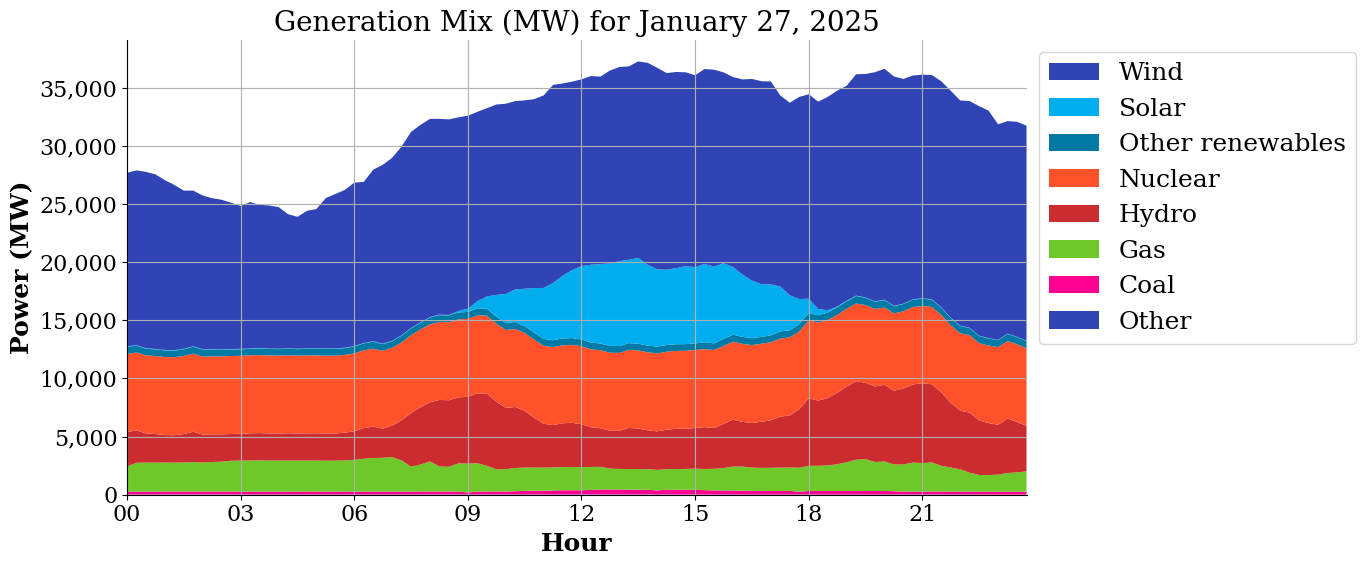

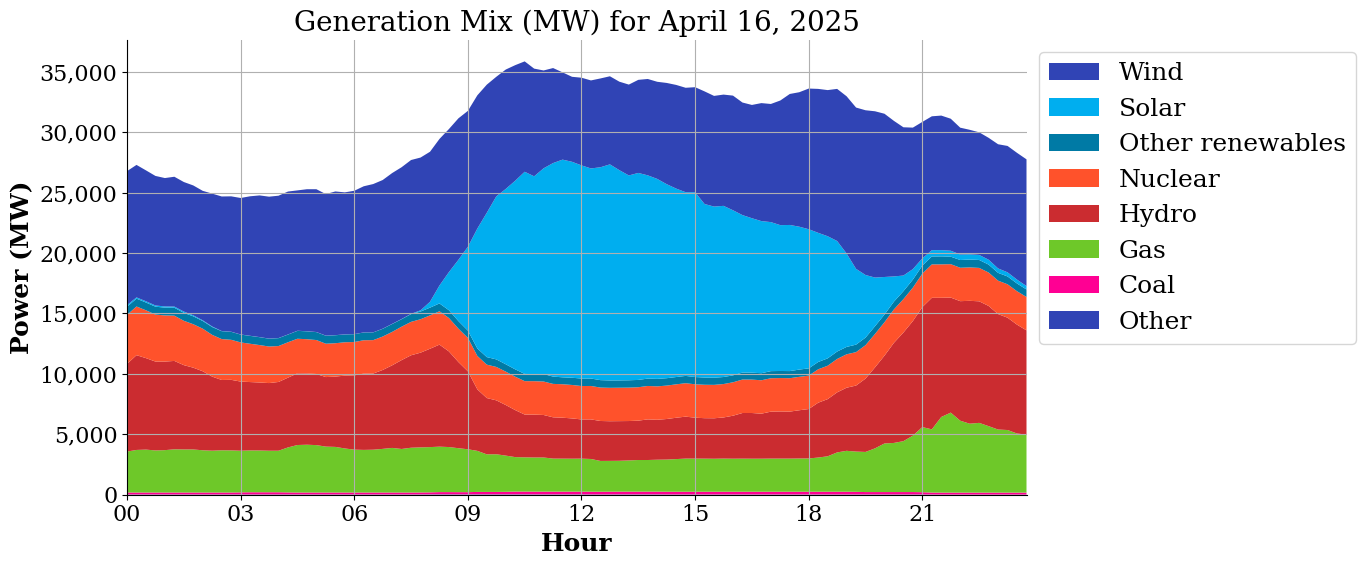

In [76]:
# Make some plots

plot_energy_stack_by_day(highest_total_day, spain_agg)
plot_energy_stack_by_day(highest_interval_day, spain_agg)
